# Imports

In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import scipy.stats as stats
import emcee
import corner
from multiprocessing import Pool, cpu_count
import copy
from scipy.interpolate import interp1d

from minot.ClusterTools import map_tools
import pitszi

import time

# Parameters

In [2]:
output_dir = '/Users/adam/Desktop/pitszi/'

In [3]:
#----- Physical model parameters
redshift = 0.5
M500 = 1e15*u.Msun
RA, Dec = 30*u.deg, 55*u.deg
axis_q1, axis_q2 = 0.7, 0.8
euler_1, euler_2, euler_3 = 40*u.deg, 50*u.deg, 15*u.deg

fluct_norm = 0.5
fluct_slope = -11./3
fluct_linj = 800*u.kpc
fluct_seed = 100

In [4]:
#----- Instrumental parameters
# Beam smoothing
beam_FWHM = 0.0*u.arcsec

# Transfer function
karcsec = np.linspace(0, 1, 1000)*u.arcsec**-1
kfov = 1/(6*60)
TF = {'k':karcsec, 'TF':1-np.exp(-karcsec.to_value('arcsec-1')/kfov)*0}

# Mask
mask_smoothing = 20*u.arcsec
mask_Ntheta500 = 0.5

# Noise
noise_k = lambda k_arcsec: 1e-9 + 3e-9 * (k_arcsec*60)**-1
noise_r = lambda r_arcsec: (1 + np.exp((r_arcsec-200)/80))*1e-10
noise_seed = 1

In [5]:
#----- Analysis parameters
# Pk measurement
Nbins_pk = 100
scale_bins = 'lin'
kmin_pk = 1/(3000)*u.arcsec**-1
kmax_pk = 1/(18*u.arcsec)#beam_FWHM.to('arcsec')
pk_method = 'naive' # 'Arevalo12', 'naive'
img_method = 'ratio' # 'subtract', 'ratio'

# Define the model

In [6]:
#===== Generate a model for the cluster and its fluctuations
mock = pitszi.Model(RA=RA, Dec=Dec, redshift=redshift, M500=M500, silent=True, output_dir=output_dir)
mock.set_pressure_profile_universal_param('A10MD')
mock.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                   'Norm': fluct_norm, 
                                   'slope': fluct_slope,
                                   'Linj': fluct_linj,
                                   'Ldis': 1*u.kpc}
mock.triaxiality = {'min_to_maj_axis_ratio':axis_q1, 'int_to_maj_axis_ratio':axis_q2,
                    'euler_angle1':euler_1, 'euler_angle2':euler_2, 'euler_angle3':euler_3}

mock.map_center = SkyCoord(mock.coord.ra, mock.coord.dec, frame="icrs")
mock.map_fov    = [5, 5]*u.arcmin
mock.map_reso  = 5.0*u.arcsec
mock.los_reso  = 10*u.kpc
mock.los_size  = 1*u.Mpc
mock.R_truncation = mock.R500*5

mock.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 59 , 59 , 101
   Pixel size :      31.4     kpc ;     5.0      arcsec
   Fov size :  [   1855.0   ,   1855.0   ] kpc ; [   4.917    ,   4.917    ] arcmin
   L.o.S. resolution :         10.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (30., 55.)>
   k min/max projected :       0.003390  /  0.098305   1/arcsec
   k min/max projected :       0.000539  /  0.015633   1/kpc
   k min/max L.o.S. (eq.) :    0.006226  /  0.311299   1/arcsec
   k min/max L.o.S. :          0.000990  /  0.049505   1/kpc
   k max Nyquist :             0.098305   1/arcsec
   k max Nyquist :             0.015633   1/kpc


# Define some data

In [7]:
#===== Initiate a data object and fake data
#----- init with 
data = pitszi.Data(np.zeros((1,1)), '')
data.output_dir = output_dir

#----- set basic IRFs
data.psf_fwhm              = beam_FWHM
data.transfer_function     = TF
data.noise_model_pk_center = noise_k
data.noise_model_radial    = noise_r

#----- Mock the data
img = data.set_image_to_mock(mock, 
                             model_seed=fluct_seed, model_no_fluctuations=False, use_model_header=True, 
                             noise_origin='model', noise_center=mock.map_center, noise_seed=noise_seed)

#----- Define the mask
ramap, decmap = map_tools.get_radec_map(data.header)
dist_map = map_tools.greatcircle(ramap, decmap, data.header['CRVAL1'], data.header['CRVAL2'])
mask = dist_map * 0 + 1
mask[dist_map > mask_Ntheta500*mock.theta500.to_value('deg')] = 0 
mask = gaussian_filter(mask, sigma=mask_smoothing.to_value('deg')/2.35/data.header['CDELT2'])
data.mask = mask

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in reciprocal
  from ipykernel import kernelapp as app


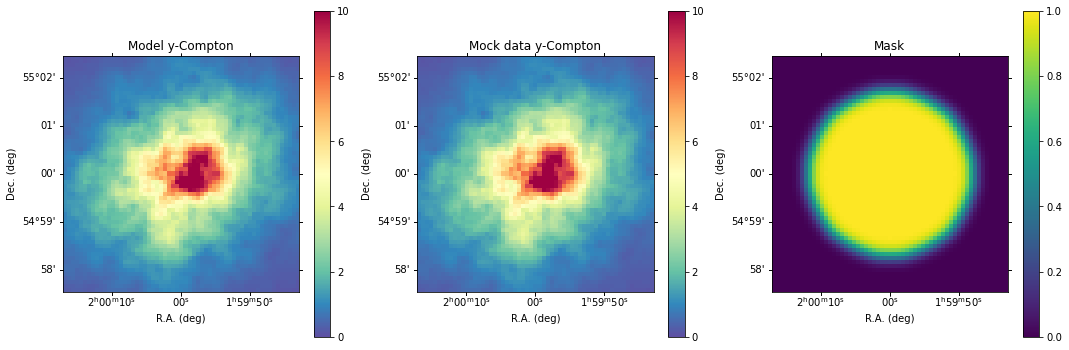

In [8]:
visu_smooth = 10

#===== Show the data
plt.rcParams.update({'font.size': 10})
fig = plt.figure(0, figsize=(18, 6))

ax = plt.subplot(1, 3, 1, projection=WCS(data.header))
plt.imshow(mock.get_sz_map(seed=fluct_seed, no_fluctuations=False)*1e5, cmap='Spectral_r', vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Model y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1,3, 2, projection=WCS(data.header))
plt.imshow(data.image*1e5, cmap='Spectral_r',vmin=0, vmax=10)
cb = plt.colorbar()
plt.title('Mock data y-Compton')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

ax = plt.subplot(1,3, 3, projection=WCS(data.header))
plt.imshow(data.mask)
cb = plt.colorbar()
plt.title('Mask')
plt.xlabel('R.A. (deg)')
plt.ylabel('Dec. (deg)')

# Derive Pk2d from Pk3d + IRFs

In [9]:
inference = pitszi.Inference(data, mock)
inference.kbin_min   = kmin_pk
inference.kbin_max   = kmax_pk
inference.kbin_Nbin  = Nbins_pk
inference.kbin_scale = scale_bins

In [10]:
fsky = np.sum(data.mask)/(data.mask.shape[0]*data.mask.shape[1])

In [11]:
# Observation
kedges = inference.get_kedges().to_value('rad-1')/mock.D_ang.to_value('kpc')
reso = inference.model.get_map_reso().to_value('rad')*mock.D_ang.to_value('kpc')

model_ymap_sph = inference.model.get_sz_map(no_fluctuations=True) 
model_ymap_sph_BeamTF = inference.model.get_sz_map(no_fluctuations=True, irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF) 
model_ymap_sph_Beam = inference.model.get_sz_map(no_fluctuations=True, irfs_convolution_beam=beam_FWHM) 

##
Nx, Ny = model_ymap_sph.shape
k_x = np.fft.fftfreq(Nx, reso)
k_y = np.fft.fftfreq(Ny, reso)
k2d_x, k2d_y = np.meshgrid(k_x, k_y, indexing='ij')
k2d_norm = np.sqrt(k2d_x**2 + k2d_y**2)
knrm = k2d_norm.flatten()    
##

Nmc = 100
#pk2d_meas_mc1 = np.zeros((Nmc, len(kedges)-1))
pk2d_meas_mc1 = np.zeros((Nmc, Nx*Ny))
pk2d_meas_mc2d = np.zeros((Nmc, Nx,Ny))
for imc in range(Nmc):
    #image = inference.model.get_sz_map(no_fluctuations=False, irfs_convolution_beam=beam_FWHM, irfs_convolution_TF=TF) 
    #data_image = (image - model_ymap_sph_BeamTF)/model_ymap_sph_Beam*inference.data.mask
    #k2d_meas1, pk2d_meas1_imc = pitszi.utils.extract_pk2d(data_image, reso, kedges=kedges)
    image = mock.get_sz_map(no_fluctuations=False) 
    data_image = (image - model_ymap_sph)/model_ymap_sph*inference.data.mask
    pk2d_meas1_imc = (np.abs(np.fft.fftn(data_image))**2).flatten() * reso**2 / (Nx*Ny)
    pk2d_meas_mc1[imc,:] = pk2d_meas1_imc
    pk2d_meas_mc2d[imc,:,:] = (np.abs(np.fft.fftn(data_image))**2) * reso**2 / (Nx*Ny)
    if imc % 10 == 0: print(imc,'/',Nmc)
pk2d_meas1 = np.mean(pk2d_meas_mc1, axis=0)
pk2d_meas2d = np.mean(pk2d_meas_mc2d, axis=0)
pk2d_meas1_std = np.std(pk2d_meas_mc1, axis=0)

0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


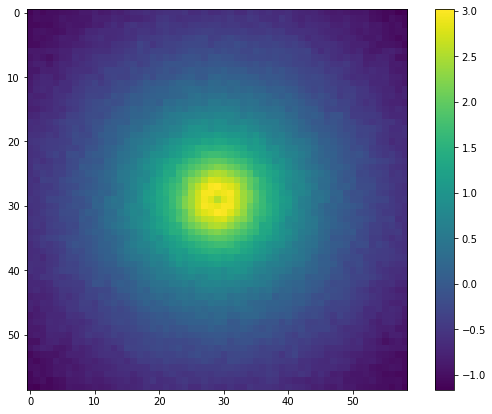

In [12]:
plt.figure(0,figsize=(10,7))
plt.imshow(np.log10(np.fft.fftshift(pk2d_meas2d)))
plt.colorbar()

In [13]:
# Theory
k3d, pk3d = inference.model.get_pressure_fluctuation_spectrum()

# Window function
WF = inference.get_p3d_to_p2d_from_window_function()
conv = np.sum(WF*inference.data.mask) / np.sum(inference.data.mask)

# p3d to p2d
k2d_exp  = k3d.to_value('kpc-1')
pk2d_exp = (pk3d*conv).to_value('kpc2')
pk2d_exp = pitszi.utils.apply_pk_beam(k2d_exp, pk2d_exp, beam_FWHM.to_value('rad')*mock.D_ang.to_value('kpc'))
pk2d_exp = pitszi.utils.apply_pk_transfer_function(k2d_exp, pk2d_exp, TF['k'].to_value('rad-1')/mock.D_ang.to_value('kpc'), TF['TF'])
pk2d_exp *= fsky

# interpolate to k2d_meas after applying the same grid
itpl = interp1d(k2d_exp, pk2d_exp, bounds_error=False,fill_value=(np.nan, np.nan))
pk2d_exp_it = itpl(knrm)

# Observation vs theory: mask
pk2d_corr = pk2d_meas1/pk2d_exp_it

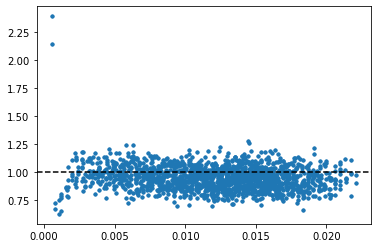

In [14]:
plt.plot(knrm, pk2d_corr, ls='', marker='.')
plt.axhline(1, ls='--', color='k')

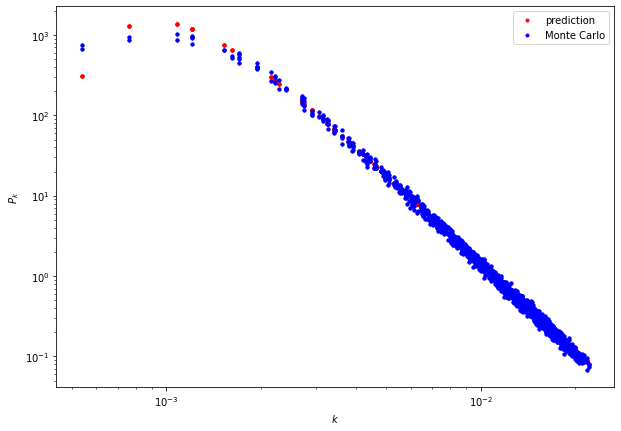

In [15]:
plt.figure(0, figsize=(10,7))
plt.loglog(knrm, pk2d_exp_it, color='r', lw=5, label='prediction', marker='.', ls='')
plt.loglog(knrm, pk2d_meas1, color='b', label='Monte Carlo', marker='.', ls='')
plt.xlabel('$k$')
plt.ylabel(r'$P_k$')
plt.legend()